# Initializing project

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import time

#for google access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_path = "../content/drive/My Drive/CSCI_534 Project/Project/Nokia Data"
# project_path = './'

nokia_stock = pd.read_csv(project_path+'/Nokia Stock Data.csv') #181 of sample
nokia_vader = pd.read_csv(project_path+'/nokia_vader.csv',index_col=0) #108817 of samples
nokia_vader.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(250446, 7)

In [3]:
nokia_vader = nokia_vader.dropna(subset=['Datetime','Text','scores'])
nokia_vader.shape #250445

(250445, 7)

In [4]:
nokia_vader['Datetime'].unique

<bound method Series.unique of 0         2020-12-06 23:59:38+00:00
1         2020-12-06 23:59:20+00:00
2         2020-12-06 23:58:27+00:00
3         2020-12-06 23:58:22+00:00
4         2020-12-06 23:57:43+00:00
                    ...            
250441    2021-02-07 00:03:26+00:00
250442    2021-02-07 00:03:26+00:00
250443    2021-02-07 00:02:50+00:00
250444    2021-02-07 00:00:34+00:00
250445    2021-02-07 00:00:27+00:00
Name: Datetime, Length: 250445, dtype: object>

# Preparing data
In this part, we will combine and prepare the data is neccessary for the model to learn such as date, stock price and vader scores.

Preparing data for nokia

In [5]:
#In this part we are preparing data for processing (taking datetime and scores from vader data)
nokia_vader_date = nokia_vader['Datetime'].to_numpy()
nokia_vader_scores = nokia_vader['scores'].to_numpy()

NEG = 1
NEU = 3
POS = 5
COM = -1 #remove '}'

In [6]:
#Cleaning nokia data
nokia_vader_neg =[]
nokia_vader_neu =[]
nokia_vader_pos =[]
nokia_vader_com =[] #don't know if needed
for i in range(len(nokia_vader_date)):
  nokia_vader_date[i] = nokia_vader_date[i].split()[0]    #cleaning the data only the date
  #change date fromat
  #mm/dd/yyy
  nokia_vader_date[i]=time.strptime(nokia_vader_date[i],'%Y-%m-%d') 
  nokia_vader_date[i]=time.strftime('%m/%d/%Y',nokia_vader_date[i])

  res = nokia_vader_scores[i].replace(',','').split()
  nokia_vader_neg.append(float(res[NEG]))
  nokia_vader_neu.append(float(res[NEU]))
  nokia_vader_pos.append(float(res[POS]))
  nokia_vader_com.append(float(res[COM].replace("}","")))


In [7]:
#put nokia vader data in df
nokia_vader_df = pd.DataFrame({
    'Date':nokia_vader_date,
    'neg':nokia_vader_neg,
    'neu':nokia_vader_neu,
    'pos':nokia_vader_pos,
    'com':nokia_vader_com
})
#combine data on the same date(caculate the descriptive statistics of "neg","neu","pos","com")
#mean
nokia_vader_df_mean = nokia_vader_df.groupby(['Date']).agg({'neg':np.mean,'neu':np.mean,'pos':np.mean,'com':np.mean}).reset_index()
#median
nokia_vader_df_median = nokia_vader_df.groupby(['Date']).agg({'neg':np.median,'neu':np.median,'pos':np.median,'com':np.median}).reset_index()
#std
nokia_vader_df_std = nokia_vader_df.groupby(['Date']).agg({'neg':np.std,'neu':np.std,'pos':np.std,'com':np.std}).reset_index()
#max
nokia_vader_df_max = nokia_vader_df.groupby(['Date']).agg({'neg':np.max,'neu':np.max,'pos':np.max,'com':np.max}).reset_index()
#min
nokia_vader_df_min = nokia_vader_df.groupby(['Date']).agg({'neg':np.min,'neu':np.min,'pos':np.min,'com':np.min}).reset_index()
#skewness
nokia_vader_df_skewness = nokia_vader_df.groupby(['Date']).agg({'neg':stats.skew,'neu':stats.skew,'pos':stats.skew,'com':stats.skew}).reset_index()
#kurtosis
nokia_vader_df_kurtosis = nokia_vader_df.groupby(['Date']).agg({'neg':stats.kurtosis,'neu':stats.kurtosis,'pos':stats.kurtosis,'com':stats.kurtosis}).reset_index()
#Jarque-Bera
#To test if the data have normal distribution base on skewness and kurotsis


In [8]:
#clean the stock date(taking datetime and close from stock data)
nokia_stock_date = nokia_stock['Date'].to_numpy()
nokia_stock_close = nokia_stock['Close'].to_numpy()

In [9]:
#get stock date and change format
for i in range(len(nokia_stock_date)):
  nokia_stock_date[i] = nokia_stock_date[i].split()[0]
  nokia_stock_date[i]=time.strptime(nokia_stock_date[i],'%m/%d/%Y')
  nokia_stock_date[i]=time.strftime('%m/%d/%Y',nokia_stock_date[i])

In [10]:
#put nokia stock data in df
nokia_stock_df = pd.DataFrame({
    'Date':nokia_stock_date,
    'close':nokia_stock_close
})

#normalizing the stock value
nokia_stock_df['close'] = (nokia_stock_df['close'] - nokia_stock_df['close'].min()) / (nokia_stock_df['close'].max() - nokia_stock_df['close'].min())
nokia_stock_df

,Date,close
0,07/01/2020,0.329268
1,07/02/2020,0.356707
2,07/06/2020,0.405488
3,07/07/2020,0.317073
4,07/08/2020,0.268293
...,...,...
176,03/15/2021,0.314024
177,03/16/2021,0.295732
178,03/17/2021,0.307927
179,03/18/2021,0.195122


In [11]:
#merge vader mean data and stock data
nokia_merge_df_mean = pd.merge(nokia_vader_df_mean,nokia_stock_df,on='Date',how="left")
nokia_merge_df_mean = nokia_merge_df_mean.dropna().reset_index(drop=True)
nokia_merge_df_mean.shape #Only 20 days worth of data

#median
nokia_merge_df_median = pd.merge(nokia_vader_df_median,nokia_stock_df,on='Date',how="left")
nokia_merge_df_median = nokia_merge_df_median.dropna().reset_index(drop=True)

#std
nokia_merge_df_std = pd.merge(nokia_vader_df_std,nokia_stock_df,on='Date',how="left")
nokia_merge_df_std = nokia_merge_df_std.dropna().reset_index(drop=True)

#max
nokia_merge_df_max = pd.merge(nokia_vader_df_max,nokia_stock_df,on='Date',how="left")
nokia_merge_df_max = nokia_merge_df_max.dropna().reset_index(drop=True)

#min
nokia_merge_df_min = pd.merge(nokia_vader_df_min,nokia_stock_df,on='Date',how="left")
nokia_merge_df_min = nokia_merge_df_min.dropna().reset_index(drop=True)


In [12]:
nokia_merge_df_mean[['neg','neu','pos','com']][:-10].shape[0]

34

# Training the linear model

Training the linear model for nokia

In [13]:
#Creating a model based on the nokia data
#nokia_merge_df[['neg','neu','pos','com']] is the data or x or feature
#nokia_merge_df[['close']] is the label
#mean
reg_nokia_mean = LinearRegression().fit(nokia_merge_df_mean[['neg','neu','pos','com']][:-10], nokia_merge_df_mean[['close']][:-10])
#median
reg_nokia_median = LinearRegression().fit(nokia_merge_df_median[['neg','neu','pos','com']][:-10], nokia_merge_df_median[['close']][:-10])
#std
reg_nokia_std = LinearRegression().fit(nokia_merge_df_std[['neg','neu','pos','com']][:-10], nokia_merge_df_std[['close']][:-10])
#max
reg_nokia_max = LinearRegression().fit(nokia_merge_df_max[['neg','neu','pos','com']][:-10], nokia_merge_df_max[['close']][:-10])
#min
reg_nokia_min = LinearRegression().fit(nokia_merge_df_min[['neg','neu','pos','com']][:-10], nokia_merge_df_min[['close']][:-10])

# Plot the data and model of for each base line

Predict nokia model with all feature

In [14]:
#each model is predicting the label using the data that we have
#pred_nokia is a numpy array consisting the values of prediction of the nokia data that we use for the training
#mean 
pred_nokia_mean = reg_nokia_mean.predict(nokia_merge_df_mean[['neg','neu','pos','com']][-10:])
#median
pred_nokia_median = reg_nokia_median.predict(nokia_merge_df_median[['neg','neu','pos','com']][-10:])
#std
pred_nokia_std = reg_nokia_std.predict(nokia_merge_df_std[['neg','neu','pos','com']][-10:])
#max
pred_nokia_max = reg_nokia_max.predict(nokia_merge_df_max[['neg','neu','pos','com']][-10:])
#min
pred_nokia_min = reg_nokia_min.predict(nokia_merge_df_min[['neg','neu','pos','com']][-10:])

#To plot the training model
#mean 
train_nokia_mean = reg_nokia_mean.predict(nokia_merge_df_mean[['neg','neu','pos','com']][:-10])
#median
train_nokia_median = reg_nokia_median.predict(nokia_merge_df_median[['neg','neu','pos','com']][:-10])
#std
train_nokia_std = reg_nokia_std.predict(nokia_merge_df_std[['neg','neu','pos','com']][:-10])
#max
train_nokia_max = reg_nokia_max.predict(nokia_merge_df_max[['neg','neu','pos','com']][:-10])
#min
train_nokia_min = reg_nokia_min.predict(nokia_merge_df_min[['neg','neu','pos','com']][:-10])


#In this part, I am combining the data  of each company with the prediction
#mean
nokia_merge_pred_mean = pd.concat([nokia_merge_df_mean[:-10], pd.DataFrame(train_nokia_mean,columns=['pred'])], axis=1)
#median
nokia_merge_pred_median = pd.concat([nokia_merge_df_median[:-10], pd.DataFrame(train_nokia_median,columns=['pred'])], axis=1)
#std
nokia_merge_pred_std = pd.concat([nokia_merge_df_std[:-10], pd.DataFrame(train_nokia_std,columns=['pred'])], axis=1)
#max
nokia_merge_pred_max = pd.concat([nokia_merge_df_max[:-10], pd.DataFrame(train_nokia_max,columns=['pred'])], axis=1)
#min
nokia_merge_pred_min = pd.concat([nokia_merge_df_min[:-10], pd.DataFrame(train_nokia_min,columns=['pred'])], axis=1)

Display the perfomance of the model


In [15]:
from sklearn.metrics import mean_squared_error

#This is the score of the prediction/ performance of the model
#mean
nokia_score_mean = mean_squared_error(nokia_merge_df_mean[['close']][-10:], pred_nokia_mean)
#median
nokia_score_median = mean_squared_error(nokia_merge_df_median[['close']][-10:], pred_nokia_median)
#std
nokia_score_std = mean_squared_error(nokia_merge_df_std[['close']][-10:], pred_nokia_std)
#max
nokia_score_max = mean_squared_error(nokia_merge_df_max[['close']][-10:], pred_nokia_max)
#min
nokia_score_min = mean_squared_error(nokia_merge_df_min[['close']][-10:], pred_nokia_min)
[nokia_score_mean,nokia_score_median,nokia_score_std,nokia_score_max,nokia_score_min]

[0.012979457071785683,
 0.0076377315049484616,
 0.022676419865555256,
 0.013886596849528926,
 0.006068942725993081]

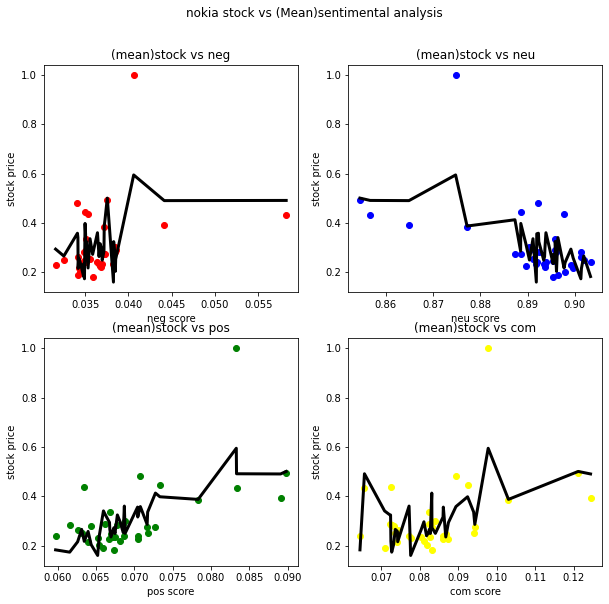

In [16]:
#plot nokia
#In this part, it is plotting the data with the stock + the model itself
#Mean sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('nokia stock vs (Mean)sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg_mean = nokia_merge_pred_mean.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg_mean[['neg']],nokia_sort_neg_mean[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(nokia_sort_neg_mean[['neg']], nokia_sort_neg_mean[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(mean)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

nokia_sort_neu_mean = nokia_merge_pred_mean.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu_mean[['neu']],nokia_sort_neu_mean[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(nokia_sort_neu_mean[['neu']], nokia_sort_neu_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(mean)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

nokia_sort_pos_mean = nokia_merge_pred_mean.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos_mean[['pos']],nokia_sort_pos_mean[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(nokia_sort_pos_mean[['pos']], nokia_sort_pos_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(mean)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

nokia_sort_com_mean = nokia_merge_pred_mean.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com_mean[['com']],nokia_sort_com_mean[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(nokia_sort_com_mean[['com']], nokia_sort_com_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(mean)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

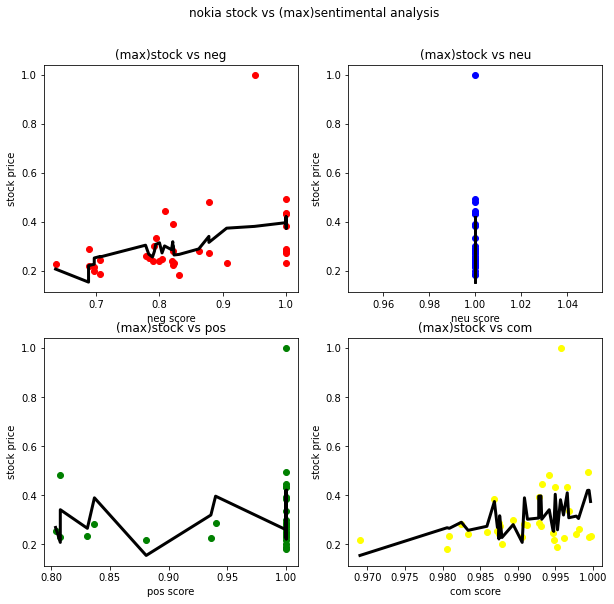

In [17]:
#Max sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('nokia stock vs (max)sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg_max = nokia_merge_pred_max.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg_max[['neg']],nokia_sort_neg_max[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(nokia_sort_neg_max[['neg']], nokia_sort_neg_max[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(max)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

nokia_sort_neu_max = nokia_merge_pred_max.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu_max[['neu']],nokia_sort_neu_max[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(nokia_sort_neu_max[['neu']], nokia_sort_neu_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(max)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

nokia_sort_pos_max = nokia_merge_pred_max.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos_max[['pos']],nokia_sort_pos_max[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(nokia_sort_pos_max[['pos']], nokia_sort_pos_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(max)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

nokia_sort_com_max = nokia_merge_pred_max.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com_max[['com']],nokia_sort_com_max[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(nokia_sort_com_max[['com']], nokia_sort_com_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(max)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

# Plot data against time

Plotting nokia stock with mean sentimental analysis


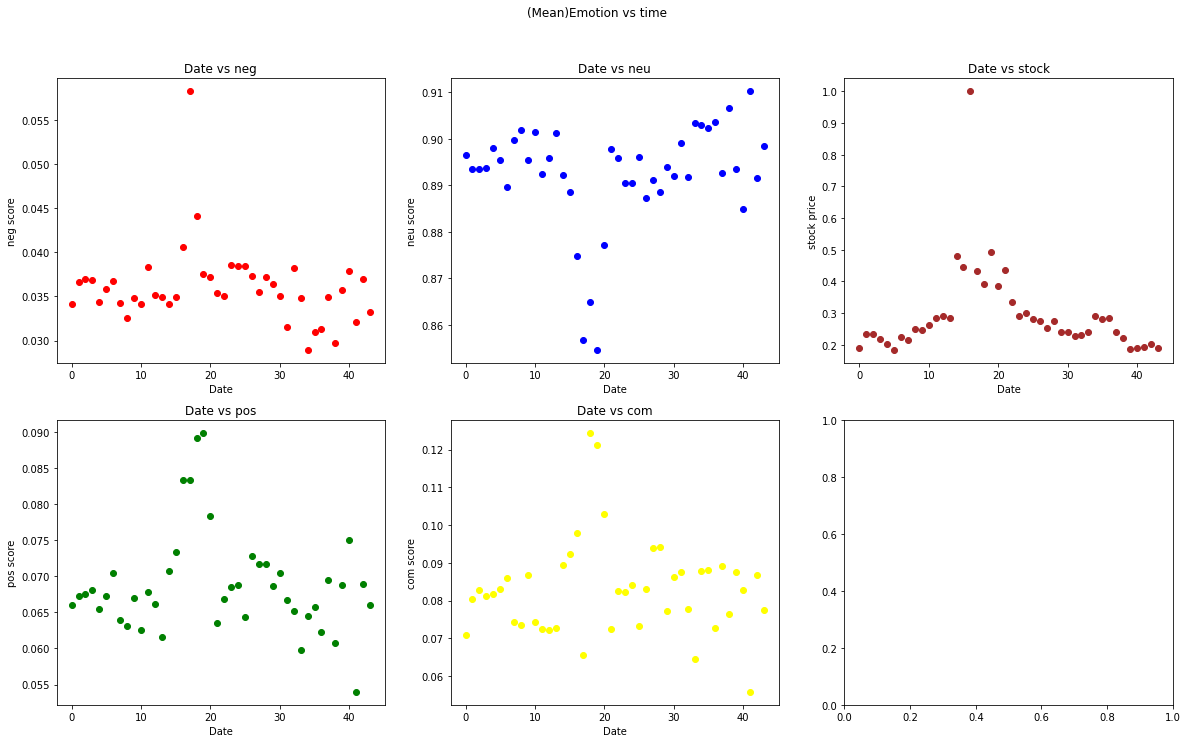

In [18]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(Mean)Emotion vs time')
fig.set_size_inches(20,10)

nokia_sort_neg_mean = nokia_merge_df_mean.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(nokia_sort_neg_mean.shape[0])],nokia_sort_neg_mean[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

nokia_sort_neu_mean = nokia_merge_df_mean.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(nokia_sort_neu_mean.shape[0])],nokia_sort_neu_mean[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

nokia_sort_pos_mean = nokia_merge_df_mean.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(nokia_sort_pos_mean.shape[0])],nokia_sort_pos_mean[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

nokia_sort_com_mean = nokia_merge_df_mean.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(nokia_sort_com_mean.shape[0])],nokia_sort_com_mean[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

nokia_sort_date = nokia_merge_df_mean.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(nokia_sort_date.shape[0])],nokia_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

In [19]:
nokia_sort_neg_mean.shape[0]

44

Plotting nokia stock with median sentimental analysis

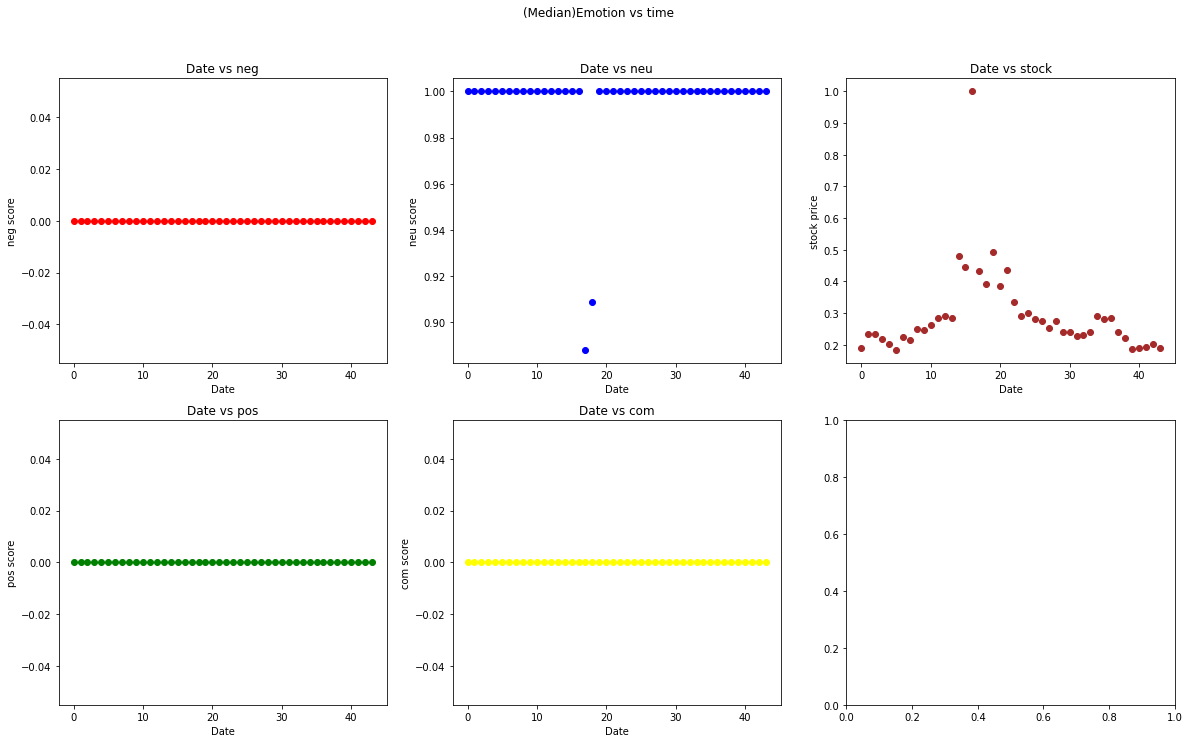

In [20]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(Median)Emotion vs time')
fig.set_size_inches(20,10)

nokia_sort_neg_median = nokia_merge_df_median.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(nokia_sort_neg_median.shape[0])],nokia_sort_neg_median[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

nokia_sort_neu_median = nokia_merge_df_median.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(nokia_sort_neu_median.shape[0])],nokia_sort_neu_median[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

nokia_sort_pos_median = nokia_merge_df_median.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(nokia_sort_pos_median.shape[0])],nokia_sort_pos_median[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

nokia_sort_com_median = nokia_merge_df_median.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(nokia_sort_com_median.shape[0])],nokia_sort_com_median[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

nokia_sort_date = nokia_merge_df_median.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(nokia_sort_date.shape[0])],nokia_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting nokia stock with std sentimental analysis

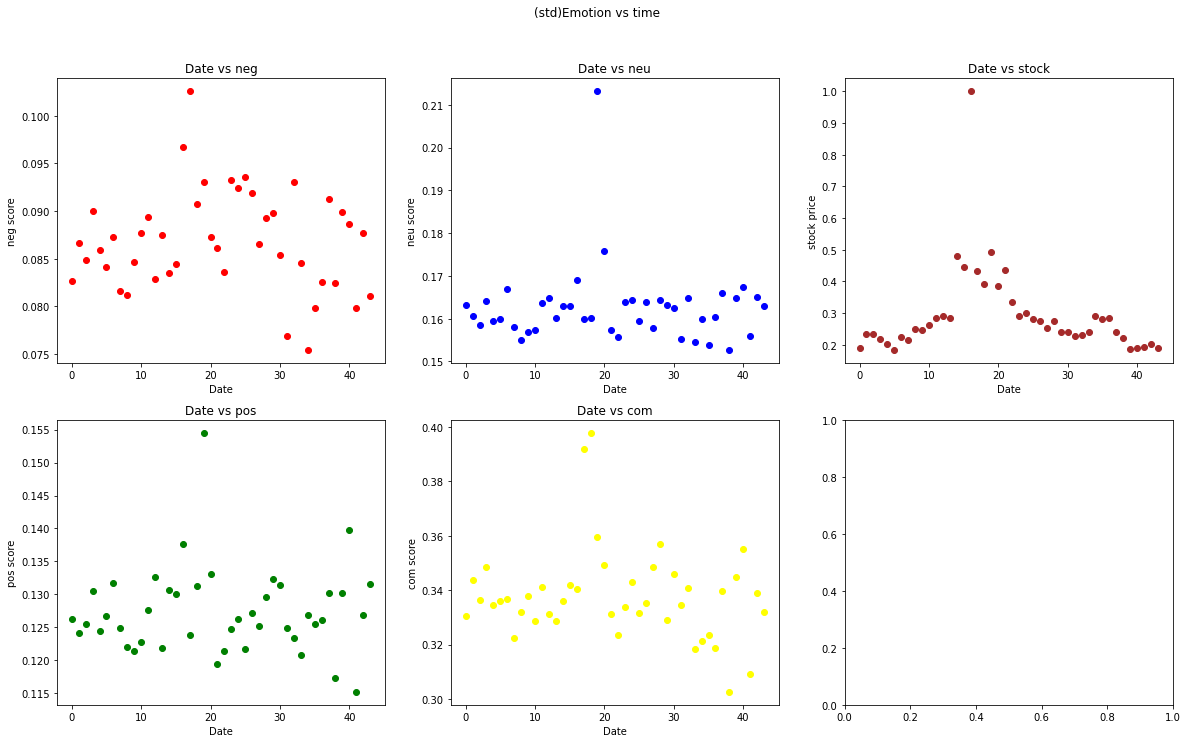

In [21]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(std)Emotion vs time')
fig.set_size_inches(20,10)

nokia_sort_neg_std = nokia_merge_df_std.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(nokia_sort_neg_std.shape[0])],nokia_sort_neg_std[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

nokia_sort_neu_std = nokia_merge_df_std.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(nokia_sort_neu_std.shape[0])],nokia_sort_neu_std[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

nokia_sort_pos_std = nokia_merge_df_std.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(nokia_sort_pos_std.shape[0])],nokia_sort_pos_std[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

nokia_sort_com_std = nokia_merge_df_std.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(nokia_sort_com_std.shape[0])],nokia_sort_com_std[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

nokia_sort_date = nokia_merge_df_std.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(nokia_sort_date.shape[0])],nokia_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting nokia stock with maximum sentimental analysis

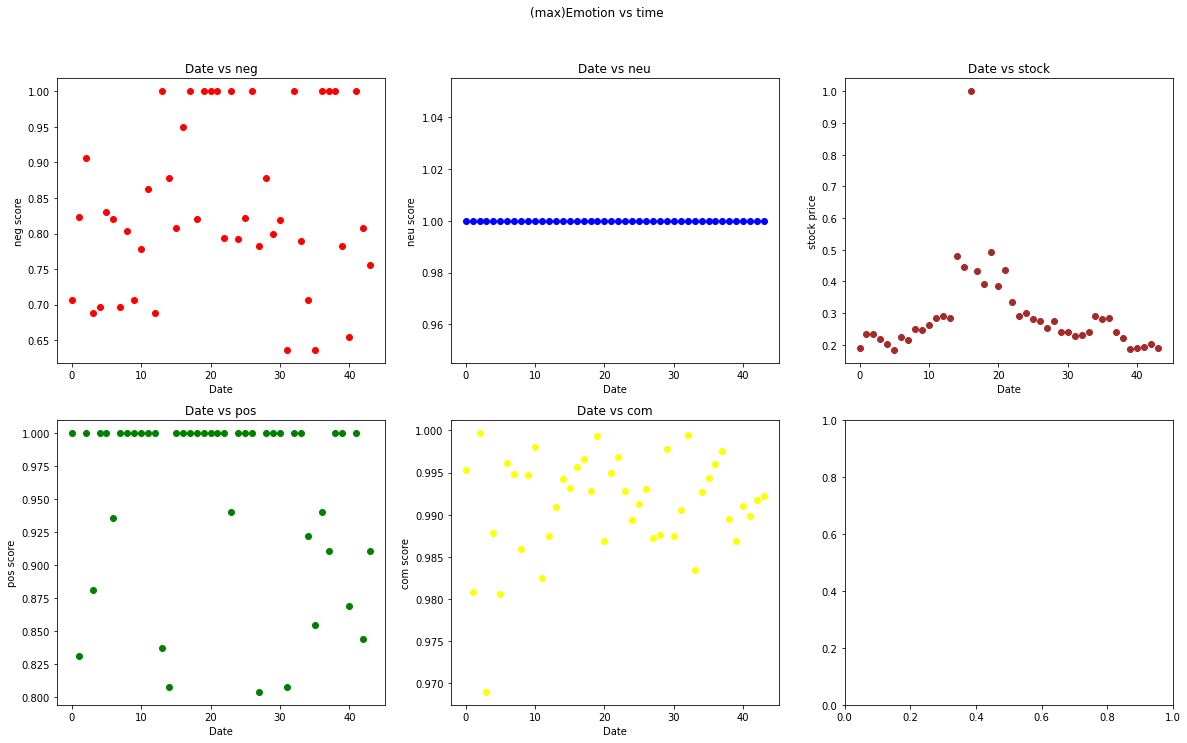

In [22]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(max)Emotion vs time')
fig.set_size_inches(20,10)

nokia_sort_neg_max = nokia_merge_df_max.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(nokia_sort_neg_max.shape[0])],nokia_sort_neg_max[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

nokia_sort_neu_max = nokia_merge_df_max.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(nokia_sort_neu_max.shape[0])],nokia_sort_neu_max[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

nokia_sort_pos_max = nokia_merge_df_max.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(nokia_sort_pos_max.shape[0])],nokia_sort_pos_max[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

nokia_sort_com_max = nokia_merge_df_max.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(nokia_sort_com_max.shape[0])],nokia_sort_com_max[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

nokia_sort_date = nokia_merge_df_max.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(nokia_sort_date.shape[0])],nokia_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting nokia stock with minimum sentimental analysis

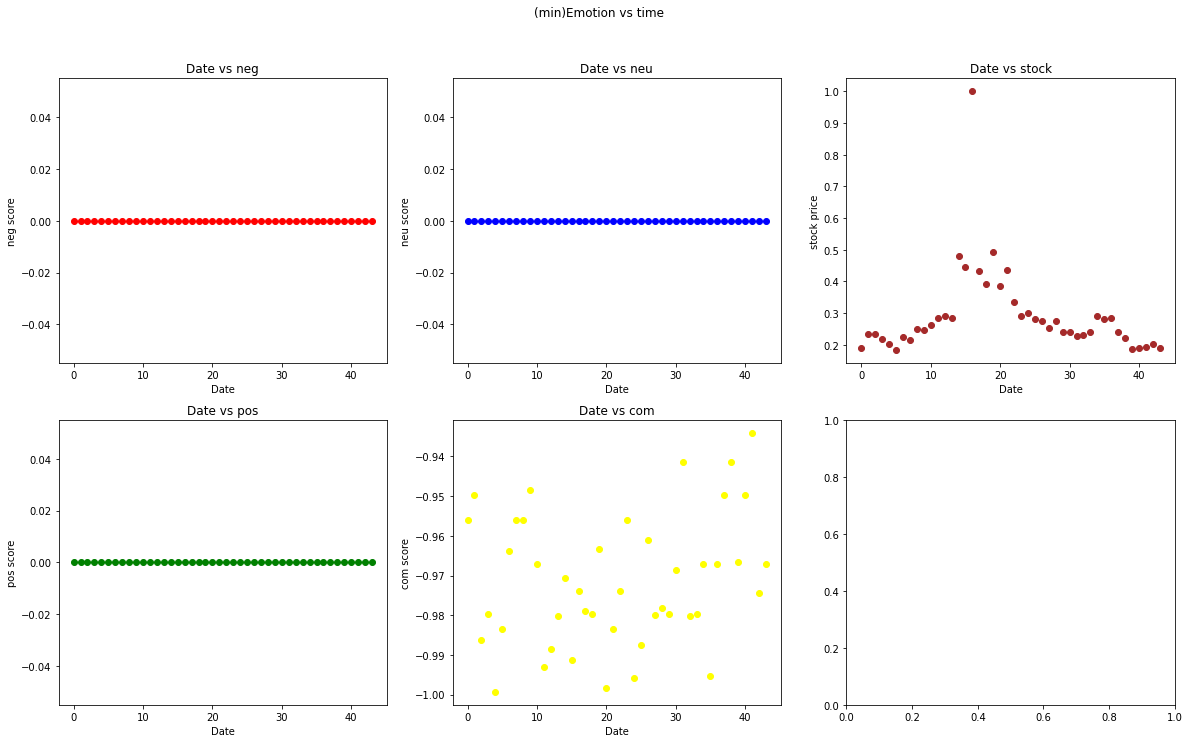

In [23]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(min)Emotion vs time')
fig.set_size_inches(20,10)

nokia_sort_neg_min = nokia_merge_df_min.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(nokia_sort_neg_min.shape[0])],nokia_sort_neg_min[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

nokia_sort_neu_min = nokia_merge_df_min.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(nokia_sort_neu_min.shape[0])],nokia_sort_neu_min[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

nokia_sort_pos_min = nokia_merge_df_min.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(nokia_sort_pos_min.shape[0])],nokia_sort_pos_min[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

nokia_sort_com_min = nokia_merge_df_min.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(nokia_sort_com_min.shape[0])],nokia_sort_com_min[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

nokia_sort_date = nokia_merge_df_min.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(nokia_sort_date.shape[0])],nokia_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

# Training with different method

Training with mean sentimental analysis

In [24]:
#Training models based on the nokia data for four features(neg,neu,pos,com) separately
reg_nokia_neg_mean = LinearRegression().fit(nokia_merge_df_mean[['neg']][:-10], nokia_merge_df_mean[['close']][:-10])
reg_nokia_neu_mean = LinearRegression().fit(nokia_merge_df_mean[['neu']][:-10], nokia_merge_df_mean[['close']][:-10])
reg_nokia_pos_mean = LinearRegression().fit(nokia_merge_df_mean[['pos']][:-10], nokia_merge_df_mean[['close']][:-10])
reg_nokia_com_mean = LinearRegression().fit(nokia_merge_df_mean[['com']][:-10], nokia_merge_df_mean[['close']][:-10])

In [25]:
#predict the stock price of nokia using new models
pred_nokia_neg_mean = reg_nokia_neg_mean.predict(nokia_merge_df_mean[['neg']][-10:])
pred_nokia_neu_mean = reg_nokia_neu_mean.predict(nokia_merge_df_mean[['neu']][-10:])
pred_nokia_pos_mean = reg_nokia_pos_mean.predict(nokia_merge_df_mean[['pos']][-10:])
pred_nokia_com_mean = reg_nokia_com_mean.predict(nokia_merge_df_mean[['com']][-10:])

#predict on the training model to plot the data
train_nokia_neg_mean = reg_nokia_neg_mean.predict(nokia_merge_df_mean[['neg']][:-10])
train_nokia_neu_mean = reg_nokia_neu_mean.predict(nokia_merge_df_mean[['neu']][:-10])
train_nokia_pos_mean = reg_nokia_pos_mean.predict(nokia_merge_df_mean[['pos']][:-10])
train_nokia_com_mean = reg_nokia_com_mean.predict(nokia_merge_df_mean[['com']][:-10])

#combine five kinds of prediction for nokia with original data
nokia_merge_pred1_mean = pd.concat([nokia_merge_df_mean[:-10], pd.DataFrame(train_nokia_neg_mean,columns=['pred_neg'])], axis=1)
nokia_merge_pred1_mean = pd.concat([nokia_merge_pred1_mean, pd.DataFrame(train_nokia_neu_mean,columns=['pred_neu'])], axis=1)
nokia_merge_pred1_mean = pd.concat([nokia_merge_pred1_mean, pd.DataFrame(train_nokia_pos_mean,columns=['pred_pos'])], axis=1)
nokia_merge_pred1_mean = pd.concat([nokia_merge_pred1_mean, pd.DataFrame(train_nokia_com_mean,columns=['pred_com'])], axis=1)

nokia_merge_pred1_mean

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.034156,0.896427,0.065962,0.070852,0.189024,0.281023,0.269939,0.264467,0.254559
1,01/05/2021,0.036599,0.893608,0.067224,0.080344,0.234756,0.307850,0.289344,0.280085,0.296444
2,01/06/2021,0.036966,0.893423,0.067465,0.082744,0.234756,0.311877,0.290619,0.283069,0.307030
3,01/07/2021,0.036881,0.893678,0.068138,0.081081,0.219512,0.310944,0.288866,0.291394,0.299695
4,01/08/2021,0.034422,0.897952,0.065415,0.081767,0.201220,0.283944,0.259436,0.257705,0.302722
5,01/11/2021,0.035858,0.895477,0.067324,0.083175,0.182927,0.299715,0.276480,0.281324,0.308931
6,01/12/2021,0.036725,0.889645,0.070440,0.086054,0.225610,0.309238,0.316632,0.319889,0.321638
7,01/13/2021,0.034258,0.899659,0.063957,0.074196,0.216463,0.282137,0.247687,0.239657,0.269315
8,01/14/2021,0.032528,0.901894,0.063115,0.073641,0.250000,0.263149,0.232293,0.229244,0.266866
9,01/15/2021,0.034836,0.895413,0.066945,0.086768,0.246951,0.288494,0.276922,0.276639,0.324786


In [26]:
nokia_score_neg_mean = mean_squared_error(nokia_merge_df_mean[['close']][-10:], pred_nokia_neg_mean)
nokia_score_neu_mean = mean_squared_error(nokia_merge_df_mean[['close']][-10:], pred_nokia_neu_mean)
nokia_score_pos_mean = mean_squared_error(nokia_merge_df_mean[['close']][-10:], pred_nokia_pos_mean)
nokia_score_com_mean = mean_squared_error(nokia_merge_df_mean[['close']][-10:], pred_nokia_com_mean)
[nokia_score_neg_mean,nokia_score_neu_mean,nokia_score_pos_mean,nokia_score_com_mean]

[0.006299599869298999,
 0.0065924734146553185,
 0.008097269851348262,
 0.007535758903773962]

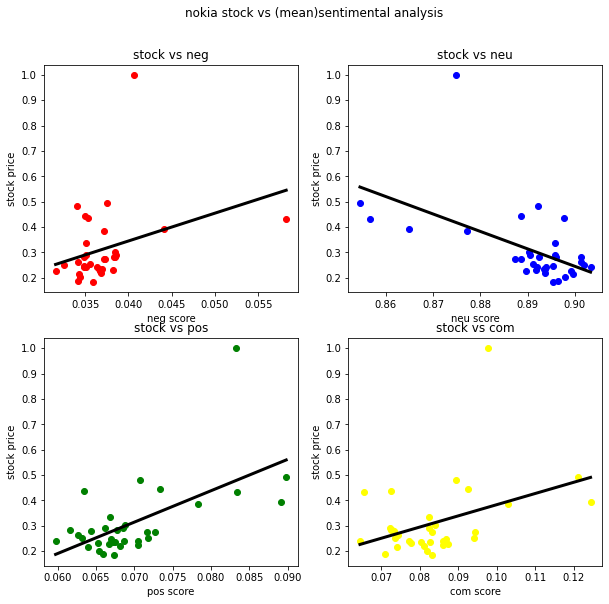

In [27]:
#plot the new nokia model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('nokia stock vs (mean)sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg_mean = nokia_merge_pred1_mean.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg_mean[['neg']],nokia_sort_neg_mean[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(nokia_sort_neg_mean[['neg']], nokia_sort_neg_mean[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

nokia_sort_neu_mean = nokia_merge_pred1_mean.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu_mean[['neu']],nokia_sort_neu_mean[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(nokia_sort_neu_mean[['neu']], nokia_sort_neu_mean[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

nokia_sort_pos_mean = nokia_merge_pred1_mean.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos_mean[['pos']],nokia_sort_pos_mean[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(nokia_sort_pos_mean[['pos']], nokia_sort_pos_mean[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

nokia_sort_com_mean = nokia_merge_pred1_mean.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com_mean[['com']],nokia_sort_com_mean[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(nokia_sort_com_mean[['com']], nokia_sort_com_mean[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with median sentimental analysis

In [28]:
#Training models based on the nokia data for four features(neg,neu,pos,com) separately
reg_nokia_neg_median = LinearRegression().fit(nokia_merge_df_median[['neg']][:-10], nokia_merge_df_median[['close']][:-10])
reg_nokia_neu_median = LinearRegression().fit(nokia_merge_df_median[['neu']][:-10], nokia_merge_df_median[['close']][:-10])
reg_nokia_pos_median = LinearRegression().fit(nokia_merge_df_median[['pos']][:-10], nokia_merge_df_median[['close']][:-10])
reg_nokia_com_median = LinearRegression().fit(nokia_merge_df_median[['com']][:-10], nokia_merge_df_median[['close']][:-10])

In [29]:
#predict the stock price of nokia using new models
pred_nokia_neg_median = reg_nokia_neg_median.predict(nokia_merge_df_median[['neg']][-10:])
pred_nokia_neu_median = reg_nokia_neu_median.predict(nokia_merge_df_median[['neu']][-10:])
pred_nokia_pos_median = reg_nokia_pos_median.predict(nokia_merge_df_median[['pos']][-10:])
pred_nokia_com_median = reg_nokia_com_median.predict(nokia_merge_df_median[['com']][-10:])

#predict on the training model to plot the data
train_nokia_neg_median = reg_nokia_neg_median.predict(nokia_merge_df_median[['neg']][:-10])
train_nokia_neu_median = reg_nokia_neu_median.predict(nokia_merge_df_median[['neu']][:-10])
train_nokia_pos_median = reg_nokia_pos_median.predict(nokia_merge_df_median[['pos']][:-10])
train_nokia_com_median = reg_nokia_com_median.predict(nokia_merge_df_median[['com']][:-10])

#combine five kinds of prediction for nokia with original data
nokia_merge_pred1_median = pd.concat([nokia_merge_df_median[:-10], pd.DataFrame(train_nokia_neg_median,columns=['pred_neg'])], axis=1)
nokia_merge_pred1_median = pd.concat([nokia_merge_pred1_median, pd.DataFrame(train_nokia_neu_median,columns=['pred_neu'])], axis=1)
nokia_merge_pred1_median = pd.concat([nokia_merge_pred1_median, pd.DataFrame(train_nokia_pos_median,columns=['pred_pos'])], axis=1)
nokia_merge_pred1_median = pd.concat([nokia_merge_pred1_median, pd.DataFrame(train_nokia_com_median,columns=['pred_com'])], axis=1)

nokia_merge_pred1_median

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.0,1.000,0.0,0.0,0.189024,0.311155,0.304728,0.311155,0.311155
1,01/05/2021,0.0,1.000,0.0,0.0,0.234756,0.311155,0.304728,0.311155,0.311155
2,01/06/2021,0.0,1.000,0.0,0.0,0.234756,0.311155,0.304728,0.311155,0.311155
3,01/07/2021,0.0,1.000,0.0,0.0,0.219512,0.311155,0.304728,0.311155,0.311155
4,01/08/2021,0.0,1.000,0.0,0.0,0.201220,0.311155,0.304728,0.311155,0.311155
5,01/11/2021,0.0,1.000,0.0,0.0,0.182927,0.311155,0.304728,0.311155,0.311155
6,01/12/2021,0.0,1.000,0.0,0.0,0.225610,0.311155,0.304728,0.311155,0.311155
7,01/13/2021,0.0,1.000,0.0,0.0,0.216463,0.311155,0.304728,0.311155,0.311155
8,01/14/2021,0.0,1.000,0.0,0.0,0.250000,0.311155,0.304728,0.311155,0.311155
9,01/15/2021,0.0,1.000,0.0,0.0,0.246951,0.311155,0.304728,0.311155,0.311155


In [30]:
nokia_score_neg_median = mean_squared_error(nokia_merge_df_median[['close']][-10:], pred_nokia_neg_median)
nokia_score_neu_median = mean_squared_error(nokia_merge_df_median[['close']][-10:], pred_nokia_neu_median)
nokia_score_pos_median = mean_squared_error(nokia_merge_df_median[['close']][-10:], pred_nokia_pos_median)
nokia_score_com_median = mean_squared_error(nokia_merge_df_median[['close']][-10:], pred_nokia_com_median)
[nokia_score_neg_median,nokia_score_neu_median,nokia_score_pos_median,nokia_score_com_median]

[0.008672544148008774,
 0.0076377315049484616,
 0.008672544148008774,
 0.008672544148008774]

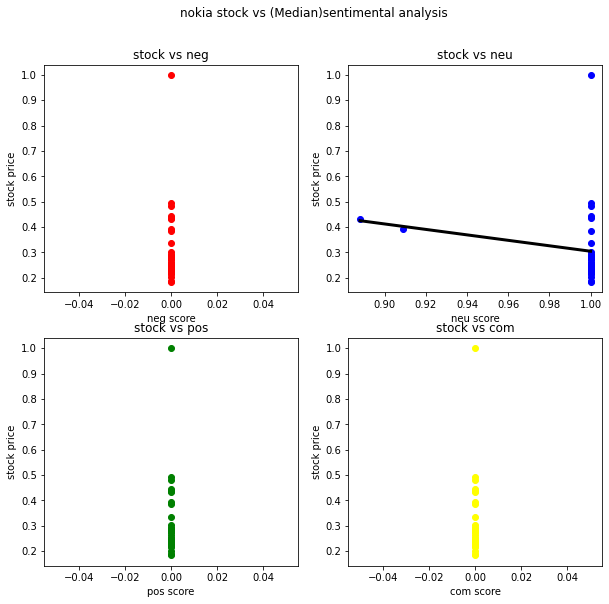

In [31]:
#plot the new nokia model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('nokia stock vs (Median)sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg_median = nokia_merge_pred1_median.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg_median[['neg']],nokia_sort_neg_median[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(nokia_sort_neg_median[['neg']], nokia_sort_neg_median[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

nokia_sort_neu_median = nokia_merge_pred1_median.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu_median[['neu']],nokia_sort_neu_median[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(nokia_sort_neu_median[['neu']], nokia_sort_neu_median[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

nokia_sort_pos_median = nokia_merge_pred1_median.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos_median[['pos']],nokia_sort_pos_median[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(nokia_sort_pos_median[['pos']], nokia_sort_pos_median[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

nokia_sort_com_median = nokia_merge_pred1_median.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com_median[['com']],nokia_sort_com_median[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(nokia_sort_com_median[['com']], nokia_sort_com_median[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with std sentimental analysis

In [32]:
#Training models based on the nokia data for four features(neg,neu,pos,com) separately
reg_nokia_neg_std = LinearRegression().fit(nokia_merge_df_std[['neg']][:-10], nokia_merge_df_std[['close']][:-10])
reg_nokia_neu_std = LinearRegression().fit(nokia_merge_df_std[['neu']][:-10], nokia_merge_df_std[['close']][:-10])
reg_nokia_pos_std = LinearRegression().fit(nokia_merge_df_std[['pos']][:-10], nokia_merge_df_std[['close']][:-10])
reg_nokia_com_std = LinearRegression().fit(nokia_merge_df_std[['com']][:-10], nokia_merge_df_std[['close']][:-10])

In [33]:
#predict the stock price of nokia using new models
pred_nokia_neg_std = reg_nokia_neg_std.predict(nokia_merge_df_std[['neg']][-10:])
pred_nokia_neu_std = reg_nokia_neu_std.predict(nokia_merge_df_std[['neu']][-10:])
pred_nokia_pos_std = reg_nokia_pos_std.predict(nokia_merge_df_std[['pos']][-10:])
pred_nokia_com_std = reg_nokia_com_std.predict(nokia_merge_df_std[['com']][-10:])

#predict on the training model to plot the data
train_nokia_neg_std = reg_nokia_neg_std.predict(nokia_merge_df_std[['neg']][:-10])
train_nokia_neu_std = reg_nokia_neu_std.predict(nokia_merge_df_std[['neu']][:-10])
train_nokia_pos_std = reg_nokia_pos_std.predict(nokia_merge_df_std[['pos']][:-10])
train_nokia_com_std = reg_nokia_com_std.predict(nokia_merge_df_std[['com']][:-10])

#combine five kinds of prediction for nokia with original data
nokia_merge_pred1_std = pd.concat([nokia_merge_df_std[:-10], pd.DataFrame(train_nokia_neg_std,columns=['pred_neg'])], axis=1)
nokia_merge_pred1_std = pd.concat([nokia_merge_pred1_std, pd.DataFrame(train_nokia_neu_std,columns=['pred_neu'])], axis=1)
nokia_merge_pred1_std = pd.concat([nokia_merge_pred1_std, pd.DataFrame(train_nokia_pos_std,columns=['pred_pos'])], axis=1)
nokia_merge_pred1_std = pd.concat([nokia_merge_pred1_std, pd.DataFrame(train_nokia_com_std,columns=['pred_com'])], axis=1)

nokia_merge_pred1_std

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.082676,0.163210,0.126275,0.330529,0.189024,0.247289,0.312483,0.299473,0.288277
1,01/05/2021,0.086617,0.160561,0.124182,0.343891,0.234756,0.297497,0.298842,0.277854,0.318846
2,01/06/2021,0.084835,0.158425,0.125525,0.336397,0.234756,0.274791,0.287846,0.291721,0.301703
3,01/07/2021,0.090045,0.164254,0.130484,0.348519,0.219512,0.341174,0.317856,0.342933,0.329433
4,01/08/2021,0.085877,0.159569,0.124417,0.334667,0.201220,0.288065,0.293738,0.280282,0.297745
5,01/11/2021,0.084167,0.159926,0.126657,0.336013,0.182927,0.266283,0.295575,0.303412,0.300823
6,01/12/2021,0.087264,0.166988,0.131760,0.336856,0.225610,0.305738,0.331937,0.356113,0.302751
7,01/13/2021,0.081613,0.158106,0.124933,0.322546,0.216463,0.233740,0.286202,0.285617,0.270013
8,01/14/2021,0.081190,0.155018,0.122044,0.332020,0.250000,0.228359,0.270300,0.255783,0.291689
9,01/15/2021,0.084711,0.156832,0.121367,0.337928,0.246951,0.273213,0.279644,0.248785,0.305205


In [34]:
nokia_score_neg_std = mean_squared_error(nokia_merge_df_std[['close']][-10:], pred_nokia_neg_std)
nokia_score_neu_std = mean_squared_error(nokia_merge_df_std[['close']][-10:], pred_nokia_neu_std)
nokia_score_pos_std = mean_squared_error(nokia_merge_df_std[['close']][-10:], pred_nokia_pos_std)
nokia_score_com_std = mean_squared_error(nokia_merge_df_std[['close']][-10:], pred_nokia_com_std)
[nokia_score_neg_std,nokia_score_neu_std,nokia_score_pos_std,nokia_score_com_std]

[0.009393847500553196,
 0.008482565303184603,
 0.013464829071718792,
 0.007219606867673099]

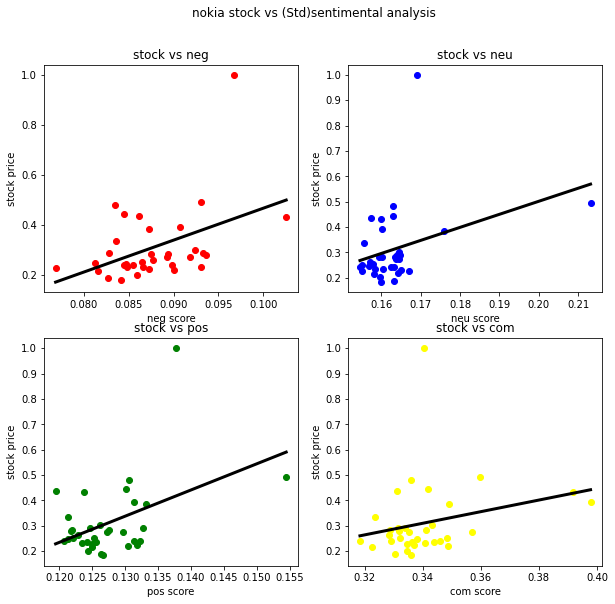

In [35]:
#plot the new nokia model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('nokia stock vs (Std)sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg_std = nokia_merge_pred1_std.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg_std[['neg']],nokia_sort_neg_std[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(nokia_sort_neg_std[['neg']], nokia_sort_neg_std[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

nokia_sort_neu_std = nokia_merge_pred1_std.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu_std[['neu']],nokia_sort_neu_std[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(nokia_sort_neu_std[['neu']], nokia_sort_neu_std[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

nokia_sort_pos_std = nokia_merge_pred1_std.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos_std[['pos']],nokia_sort_pos_std[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(nokia_sort_pos_std[['pos']], nokia_sort_pos_std[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

nokia_sort_com_std = nokia_merge_pred1_std.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com_std[['com']],nokia_sort_com_std[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(nokia_sort_com_std[['com']], nokia_sort_com_std[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with maximum sentimental analysis

In [36]:
#Training models based on the nokia data for four features(neg,neu,pos,com) separately
reg_nokia_neg_max = LinearRegression().fit(nokia_merge_df_max[['neg']][:-10], nokia_merge_df_max[['close']][:-10])
reg_nokia_neu_max = LinearRegression().fit(nokia_merge_df_max[['neu']][:-10], nokia_merge_df_max[['close']][:-10])
reg_nokia_pos_max = LinearRegression().fit(nokia_merge_df_max[['pos']][:-10], nokia_merge_df_max[['close']][:-10])
reg_nokia_com_max = LinearRegression().fit(nokia_merge_df_max[['com']][:-10], nokia_merge_df_max[['close']][:-10])

In [37]:
#predict the stock price of nokia using new models
pred_nokia_neg_max = reg_nokia_neg_max.predict(nokia_merge_df_max[['neg']][-10:])
pred_nokia_neu_max = reg_nokia_neu_max.predict(nokia_merge_df_max[['neu']][-10:])
pred_nokia_pos_max = reg_nokia_pos_max.predict(nokia_merge_df_max[['pos']][-10:])
pred_nokia_com_max = reg_nokia_com_max.predict(nokia_merge_df_max[['com']][-10:])

#predict on the training model to plot the data
train_nokia_neg_max = reg_nokia_neg_max.predict(nokia_merge_df_max[['neg']][:-10])
train_nokia_neu_max = reg_nokia_neu_max.predict(nokia_merge_df_max[['neu']][:-10])
train_nokia_pos_max = reg_nokia_pos_max.predict(nokia_merge_df_max[['pos']][:-10])
train_nokia_com_max = reg_nokia_com_max.predict(nokia_merge_df_max[['com']][:-10])

#combine five kinds of prediction for nokia with original data
nokia_merge_pred1_max = pd.concat([nokia_merge_df_max[:-10], pd.DataFrame(train_nokia_neg_max,columns=['pred_neg'])], axis=1)
nokia_merge_pred1_max = pd.concat([nokia_merge_pred1_max, pd.DataFrame(train_nokia_neu_max,columns=['pred_neu'])], axis=1)
nokia_merge_pred1_max = pd.concat([nokia_merge_pred1_max, pd.DataFrame(train_nokia_pos_max,columns=['pred_pos'])], axis=1)
nokia_merge_pred1_max = pd.concat([nokia_merge_pred1_max, pd.DataFrame(train_nokia_com_max,columns=['pred_com'])], axis=1)

nokia_merge_pred1_max

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.706,1.0,1.000,0.9953,0.189024,0.234914,0.311155,0.317856,0.338326
1,01/05/2021,0.823,1.0,0.831,0.9809,0.234756,0.301235,0.311155,0.284520,0.246896
2,01/06/2021,0.906,1.0,1.000,0.9997,0.234756,0.348284,0.311155,0.317856,0.366264
3,01/07/2021,0.688,1.0,0.881,0.9690,0.219512,0.224710,0.311155,0.294383,0.171338
4,01/08/2021,0.697,1.0,1.000,0.9879,0.201220,0.229812,0.311155,0.317856,0.291341
5,01/11/2021,0.831,1.0,1.000,0.9806,0.182927,0.305770,0.311155,0.317856,0.244991
6,01/12/2021,0.821,1.0,0.936,0.9961,0.225610,0.300101,0.311155,0.305232,0.343406
7,01/13/2021,0.697,1.0,1.000,0.9948,0.216463,0.229812,0.311155,0.317856,0.335152
8,01/14/2021,0.804,1.0,1.000,0.9859,0.250000,0.290465,0.311155,0.317856,0.278642
9,01/15/2021,0.706,1.0,1.000,0.9947,0.246951,0.234914,0.311155,0.317856,0.334517


In [38]:
nokia_score_neg_max = mean_squared_error(nokia_merge_df_max[['close']][-10:], pred_nokia_neg_max)
nokia_score_neu_max = mean_squared_error(nokia_merge_df_max[['close']][-10:], pred_nokia_neu_max)
nokia_score_pos_max = mean_squared_error(nokia_merge_df_max[['close']][-10:], pred_nokia_pos_max)
nokia_score_com_max = mean_squared_error(nokia_merge_df_max[['close']][-10:], pred_nokia_com_max)
[nokia_score_neg_max,nokia_score_neu_max,nokia_score_pos_max,nokia_score_com_max]

[0.01486994564628801,
 0.008672544148008774,
 0.007693810766535809,
 0.009327818691725966]

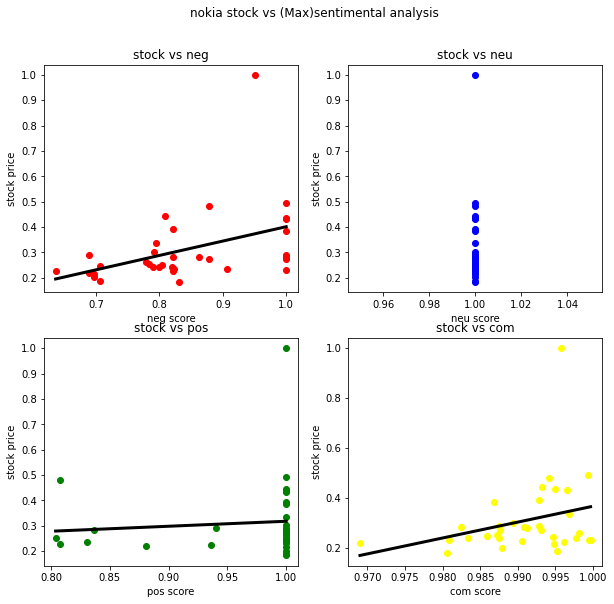

In [39]:
#plot the new nokia model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('nokia stock vs (Max)sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg_max = nokia_merge_pred1_max.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg_max[['neg']],nokia_sort_neg_max[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(nokia_sort_neg_max[['neg']], nokia_sort_neg_max[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

nokia_sort_neu_max = nokia_merge_pred1_max.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu_max[['neu']],nokia_sort_neu_max[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(nokia_sort_neu_max[['neu']], nokia_sort_neu_max[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

nokia_sort_pos_max = nokia_merge_pred1_max.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos_max[['pos']],nokia_sort_pos_max[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(nokia_sort_pos_max[['pos']], nokia_sort_pos_max[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

nokia_sort_com_max = nokia_merge_pred1_max.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com_max[['com']],nokia_sort_com_max[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(nokia_sort_com_max[['com']], nokia_sort_com_max[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with minimum sentimental analysis

In [40]:
#Training models based on the nokia data for four features(neg,neu,pos,com) separately
reg_nokia_neg_min = LinearRegression().fit(nokia_merge_df_min[['neg']][:-10], nokia_merge_df_min[['close']][:-10])
reg_nokia_neu_min = LinearRegression().fit(nokia_merge_df_min[['neu']][:-10], nokia_merge_df_min[['close']][:-10])
reg_nokia_pos_min = LinearRegression().fit(nokia_merge_df_min[['pos']][:-10], nokia_merge_df_min[['close']][:-10])
reg_nokia_com_min = LinearRegression().fit(nokia_merge_df_min[['com']][:-10], nokia_merge_df_min[['close']][:-10])

In [41]:
#predict the stock price of nokia using new models
pred_nokia_neg_min = reg_nokia_neg_min.predict(nokia_merge_df_min[['neg']][-10:])
pred_nokia_neu_min = reg_nokia_neu_min.predict(nokia_merge_df_min[['neu']][-10:])
pred_nokia_pos_min = reg_nokia_pos_min.predict(nokia_merge_df_min[['pos']][-10:])
pred_nokia_com_min = reg_nokia_com_min.predict(nokia_merge_df_min[['com']][-10:])

#predict on the training model to plot the data
train_nokia_neg_min = reg_nokia_neg_min.predict(nokia_merge_df_min[['neg']][:-10])
train_nokia_neu_min = reg_nokia_neu_min.predict(nokia_merge_df_min[['neu']][:-10])
train_nokia_pos_min = reg_nokia_pos_min.predict(nokia_merge_df_min[['pos']][:-10])
train_nokia_com_min = reg_nokia_com_min.predict(nokia_merge_df_min[['com']][:-10])

#combine five kinds of prediction for nokia with original data
nokia_merge_pred1_min = pd.concat([nokia_merge_df_min[:-10], pd.DataFrame(train_nokia_neg_min,columns=['pred_neg'])], axis=1)
nokia_merge_pred1_min = pd.concat([nokia_merge_pred1_min, pd.DataFrame(train_nokia_neu_min,columns=['pred_neu'])], axis=1)
nokia_merge_pred1_min = pd.concat([nokia_merge_pred1_min, pd.DataFrame(train_nokia_pos_min,columns=['pred_pos'])], axis=1)
nokia_merge_pred1_min = pd.concat([nokia_merge_pred1_min, pd.DataFrame(train_nokia_com_min,columns=['pred_com'])], axis=1)

nokia_merge_pred1_min

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.0,0.0,0.0,-0.9559,0.189024,0.311155,0.311155,0.311155,0.290145
1,01/05/2021,0.0,0.0,0.0,-0.9496,0.234756,0.311155,0.311155,0.311155,0.282965
2,01/06/2021,0.0,0.0,0.0,-0.9862,0.234756,0.311155,0.311155,0.311155,0.324677
3,01/07/2021,0.0,0.0,0.0,-0.9796,0.219512,0.311155,0.311155,0.311155,0.317155
4,01/08/2021,0.0,0.0,0.0,-0.9993,0.201220,0.311155,0.311155,0.311155,0.339606
5,01/11/2021,0.0,0.0,0.0,-0.9834,0.182927,0.311155,0.311155,0.311155,0.321486
6,01/12/2021,0.0,0.0,0.0,-0.9638,0.225610,0.311155,0.311155,0.311155,0.299148
7,01/13/2021,0.0,0.0,0.0,-0.9559,0.216463,0.311155,0.311155,0.311155,0.290145
8,01/14/2021,0.0,0.0,0.0,-0.9559,0.250000,0.311155,0.311155,0.311155,0.290145
9,01/15/2021,0.0,0.0,0.0,-0.9485,0.246951,0.311155,0.311155,0.311155,0.281711


In [42]:
nokia_score_neg_min = mean_squared_error(nokia_merge_df_min[['close']][-10:], pred_nokia_neg_min)
nokia_score_neu_min = mean_squared_error(nokia_merge_df_min[['close']][-10:], pred_nokia_neu_min)
nokia_score_pos_min = mean_squared_error(nokia_merge_df_min[['close']][-10:], pred_nokia_pos_min)
nokia_score_com_min = mean_squared_error(nokia_merge_df_min[['close']][-10:], pred_nokia_com_min)
[nokia_score_neg_min,nokia_score_neu_min,nokia_score_pos_min,nokia_score_com_min]

[0.008672544148008774,
 0.008672544148008774,
 0.008672544148008774,
 0.006068942725993081]

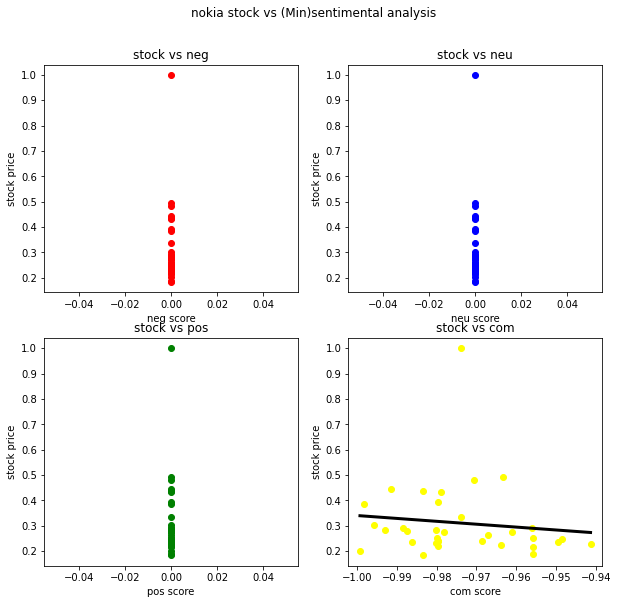

In [44]:
#plot the new nokia model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('nokia stock vs (Min)sentimental analysis')
fig.set_size_inches(10,8)

nokia_sort_neg_min = nokia_merge_pred1_min.sort_values(by=['neg'])
axs[0,0].scatter(nokia_sort_neg_min[['neg']],nokia_sort_neg_min[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(nokia_sort_neg_min[['neg']], nokia_sort_neg_min[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

nokia_sort_neu_min = nokia_merge_pred1_min.sort_values(by=['neu'])
axs[0,1].scatter(nokia_sort_neu_min[['neu']],nokia_sort_neu_min[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(nokia_sort_neu_min[['neu']], nokia_sort_neu_min[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

nokia_sort_pos_min = nokia_merge_pred1_min.sort_values(by=['pos'])
axs[1,0].scatter(nokia_sort_pos_min[['pos']],nokia_sort_pos_min[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(nokia_sort_pos_min[['pos']], nokia_sort_pos_min[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

nokia_sort_com_min = nokia_merge_pred1_min.sort_values(by=['com'])
axs[1,1].scatter(nokia_sort_com_min[['com']],nokia_sort_com_min[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(nokia_sort_com_min[['com']], nokia_sort_com_min[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()